# LTEM simulations

## Some test for rewriting functions to use `df.Field` whenever possible

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(1)
#np.random.seed(1)

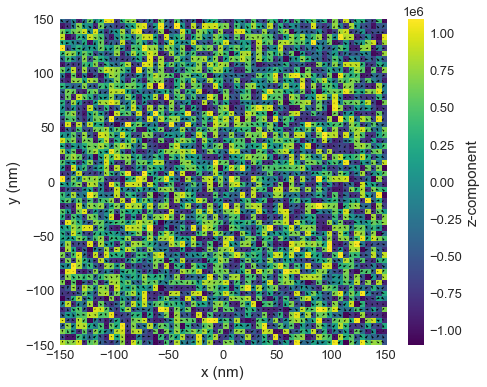

In [3]:
region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return [2*random.random()-1 for i in range(3)]
    # return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

Running OOMMF (ExeOOMMFRunner) [2021/06/09 17:12]... (8.4 s)


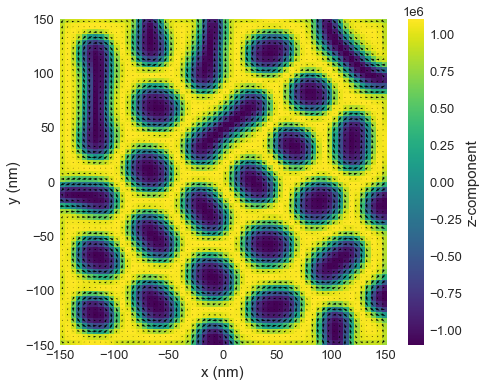

In [4]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

In [5]:
m_projection = system.m.project('z')

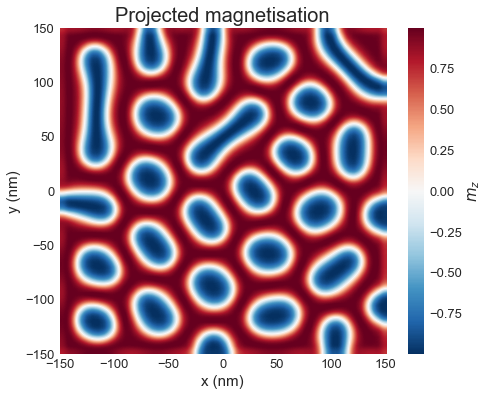

In [6]:
fig, ax = plt.subplots()
m_projection.orientation.z.mpl_scalar(ax=ax,
                                       cmap='RdBu_r',
                                       interpolation='spline16',
                                       colorbar_label=r'$m_z$')
ax.set_title('Projected magnetisation');

## Simulate LTEM

In [7]:
import exsim

In [8]:
phase, ft_phase = exsim.ltem_phase(system.m, U=300e3, Cs=8000)

The electron beam has a wavelength of 1.97e-03 nm.


---
Phase in real space

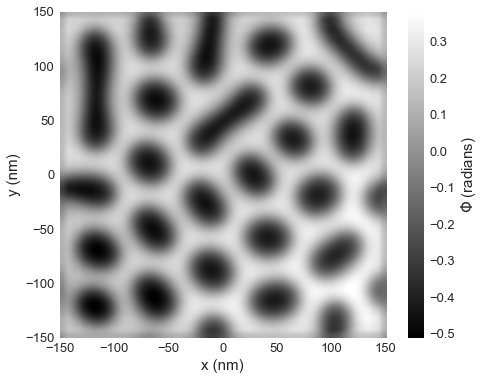

In [9]:
phase.mpl_scalar(cmap='gray',
                   interpolation='spline16',
                   colorbar_label=r'$\Phi$ (radians)')

---
Cosine of the phase

In [10]:
cos_phase = df.Field(phase.mesh, dim=1, value=np.cos(phase.array * 15))

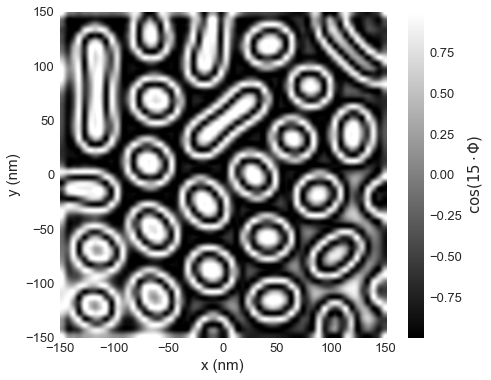

In [11]:
cos_phase.mpl_scalar(cmap='gray',
                     interpolation='spline16',
                     colorbar_label=r'$\cos(15\cdot\Phi)$')

---
Projected magnetisation

In [12]:
m_inplane_angle = df.Field(m_projection.mesh, dim=1,
                           value=np.arctan2(m_projection.y.array, m_projection.x.array))

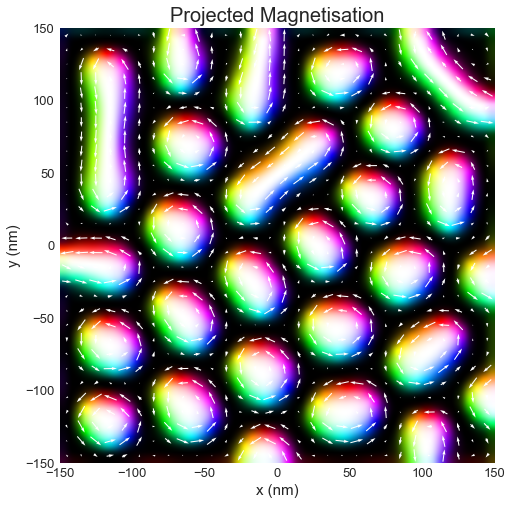

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
m_inplane_angle.mpl_scalar(ax=ax,
                           cmap='hsv',
                           interpolation='spline16',
                           lightness_field=-m_projection.z,
                           colorbar=False)
m_projection.plane('z', n=(30, 30)).mpl_vector(ax=ax, color='w', use_color=False)
ax.set_title('Projected Magnetisation');

---
Projected B-field calcuated from the phase

In [14]:
B_projected = -1 * phase.derivative('y') << phase.derivative('x')
B_angle = df.Field(B_projected.mesh, dim=1, value=np.arctan2(B_projected.y.array, B_projected.x.array))

In [15]:
B_plot = B_projected << B_angle

In [16]:
mag = np.sqrt(B_plot.x.array**2 + B_plot.y.array**2)
mag[0, 0, 0, 0] = 2 * np.max(mag)  # avoid pure white; "ruins" bottom left corner
lightness = df.Field(B_plot.mesh, dim=1, value=mag)

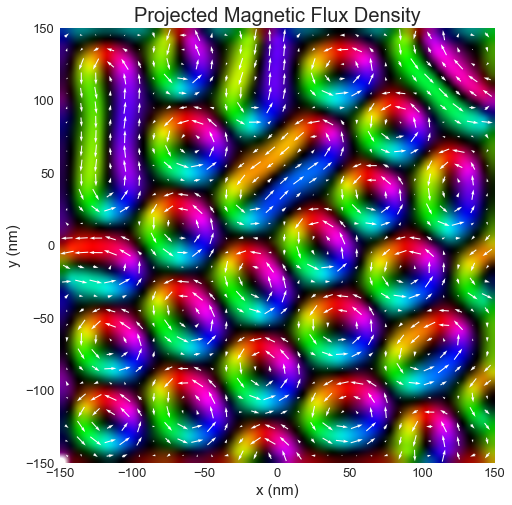

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
B_plot.z.mpl_scalar(ax=ax,
                    cmap='hsv',
                    interpolation='spline16',
                    lightness_field=lightness,
                    colorbar=False)
B_plot.plane('z', n=(30, 30)).mpl_vector(ax=ax, color='w', use_color=False)
ax.set_title('Projected Magnetic Flux Density');

We can observe a 180 degree phase shift in the colours compared to Sam's notebook. Is there an agreed-upon convention about the relation between colour and in-plane angle?